In [1]:
import categorical_data_encoding as cden
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

Import the dataset

In [2]:
data_set = pd.read_csv('C:\Python\Project\Project\data\\tmdb_5000_movies.csv', na_values=0)
data_set.set_index('id', inplace=True)

Select only the wanted features from the dataset

In [3]:
feature_names = ['budget', 'revenue', 'genres', 'popularity', 
                'production_companies', 'production_countries', 'release_date', 'runtime', 
                'spoken_languages', 'vote_average', 'vote_count']

for column in data_set.columns:
    if not feature_names.__contains__(column):
        data_set.drop(column, axis=1, inplace=True)

Remove the samples which don't have a value for the dependent variable

In [4]:
data_set.dropna(subset=['revenue'], how='any', inplace=True)

Encode the categorical fetures

In [5]:
data_set = cden.encode_data(data_set)
data_set.to_csv('C:\Python\Project\Project\data\data_set_dropped_na_revenue.csv')

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
Number of occurances of the value 1 in column other_companies: 2947
Number of occurances of the value 0 in column other_companies: 429

<class 'pandas.core.series.Series'>
Number of occurances of the value 1 in column other_countries: 203
Number of occurances of the value 0 in column other_countries: 3173

<class 'pandas.core.series.Series'>
Number of occurances of the value 1 in column other_languages: 201
Number of occurances of the value 0 in column other_languages: 3175

94
Ratio of features to samples = 1 : 35.91489361702128


In [6]:
""" for column in data_set.columns:
    n_missing = data_set[column].isna().sum()
    print("Missing values in " + column + ": " + str(n_missing)) """

' for column in data_set.columns:\n    n_missing = data_set[column].isna().sum()\n    print("Missing values in " + column + ": " + str(n_missing)) '

Test, train split

In [7]:
y = data_set['revenue']
X = data_set[data_set.columns.drop('revenue')]

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 85)


Data normalization <br />
The normalization is done before KNN imputing since KNN works better with scaled values <br />
the fit method is only applied to the train set in order to aviod data leakage

In [8]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

#quick behavior check to make sure that MinMaxScaler didn't change the order of the samples
same = True
for index in X_train.index:
    if(X_train.loc[index, 'Action'] != X_train.loc[index, 'Action']): same = False

X_train.to_csv('C:\Python\Project\Project\data\X_train_scaled.csv')

Evaluate the model using cross validation <br/>
The model and the data set require much more tuning

In [9]:
regressor = GradientBoostingRegressor(n_estimators=600, learning_rate=0.04)
imputer = KNNImputer()
pipeline = Pipeline(steps=[('i', imputer), ('r', regressor)])

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

MAE: -47706374.207 (3613775.188)


Fit the model to the train test

In [10]:
regressor = GradientBoostingRegressor()
X_train_imputed = imputer.fit_transform(X_train)
regressor.fit(X_train_imputed, y_train)
X_test_imputed = imputer.transform(X_test)
predicted = regressor.predict(X_test_imputed)

In [11]:
pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index).to_csv('C:\Python\Project\Project\data\X_train_imputed.csv')

In [12]:
y_test_df = pd.DataFrame(y_test)
print(y_test_df.columns)
y_test_df['id'] = y_test_df.index
print(y_test_df.head())

Index(['revenue'], dtype='object')
            revenue      id
id                         
13362      274661.0   13362
133694    8138788.0  133694
3877      2849142.0    3877
88751   101702060.0   88751
22      655011224.0      22


In [13]:
predicted = pd.DataFrame(predicted, columns=['revenue'])
predicted['id'] = y_test.index
print(predicted.head())

        revenue      id
0  4.227071e+06   13362
1  2.417360e+07  133694
2  1.406350e+07    3877
3  1.445675e+08   88751
4  9.469531e+08      22


In [14]:
predicted.to_csv('C:\Python\Project\Project\data\predicted.csv')
y_test_df.to_csv('C:\Python\Project\Project\data\y_test.csv')

Display the models performance

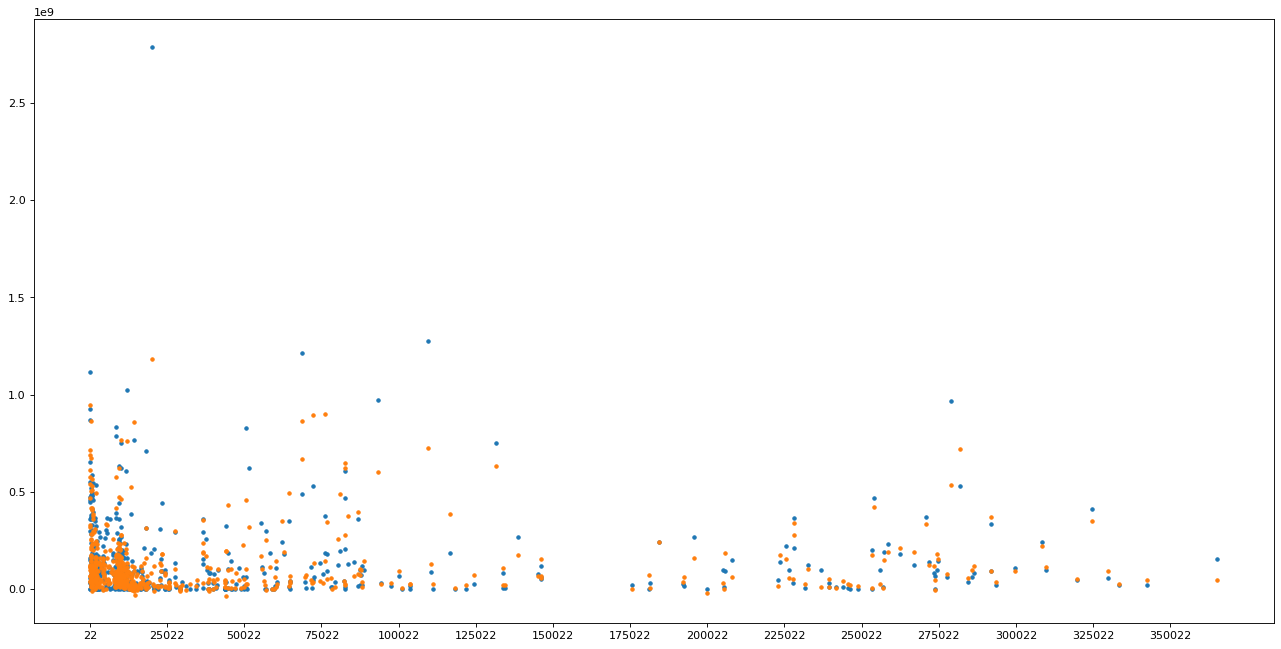

In [15]:
plt.figure(figsize=(20, 10), dpi=80)
plt.scatter(y_test_df['id'], y_test_df['revenue'], marker='.')
plt.xticks(np.arange(min(y_test.index), max(y_test.index)+5, 25000))
plt.scatter(predicted['id'], predicted['revenue'], marker='.')